##  Time-Series Cross-Validation for a Ridge Regression model


Data Source:
[National Centers for Environmental Information](https://www.ncei.noaa.gov/cdo-web/datasets#GHCND)

Data Catalog:
[GHCND_data_dictionary.pdf](https://github.com/GBlanch/Statistical-Methods/blob/main/1.Time-Series%20Cross-Validation/0.data/GHCND_data_dictionary.pdf)

Raw Data:
[3489695_phil_weather.csv](https://raw.githubusercontent.com/GBlanch/Statistical-Methods/main/1.Time-Series%20Cross-Validation/0.data/3489695_phil.csv)

### Objective


We are to train a ML Ridge Regression model to predict tomorrow's weather for each day. We will also apply TSCV to it to evaluate its accuracy. 



### Summary

Since the dataset to be used is in order of date (aka _Time Series_), we shall not use _Cross-Validation_ here to use future data to predict the past. 
Instead, we better use _Time Series Cross-Validation_ (aka _Backtesting_ in Finance ) to account for the Time-Series nature of the data.

We first place an order request so that we are sent the weather dataset. The location will be _PHL Philadelphia International Airport_, PA US. 
The data dictionary can be downloaded from the website withour prior request. Here are the details of it all:





<p align="center">
<img src="1.assets/order placement.png" alt="100" width="700"/>

Data Source:
[National Centers for Environmental Information](https://www.ncei.noaa.gov/cdo-web/datasets#GHCND)


Data Catalog:
[GHCND_data_dictionary.pdf](https://github.com/GBlanch/Statistical-Methods/blob/main/1.Time-Series%20Cross-Validation/0.data/GHCND_data_dictionary.pdf)

Raw Data:
[3489695_phil_weather.csv](https://raw.githubusercontent.com/GBlanch/Statistical-Methods/main/1.Time-Series%20Cross-Validation/0.data/3489695_phil.csv)




Next, we as usual begin importing all the dependencies we will be utilizing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge

 We then pass the URL of our raw file so that we can fetch the dataset into our dataframe:

In [2]:
df_weather = pd.read_csv("https://raw.githubusercontent.com/GBlanch/Statistical-Methods/main/1.Time-Series%20Cross-Validation/0.data/3489695_phil_weather.csv",
                         # assign the colum named DATE to be the index
                          index_col = "DATE")

In [3]:
df_weather


,STATION,NAME,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,PSUN,SNOW,...,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV03
DATE,,,,,,,,,,,,,,,,,,,,,
1973-01-01,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",40.0,30.0,NaN,NaN,NaN,0.01,77.0,0.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-02,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",40.0,30.0,NaN,NaN,NaN,0.00,81.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-03,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",70.0,100.0,NaN,NaN,NaN,0.06,59.0,0.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-04,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",80.0,90.0,NaN,NaN,NaN,0.50,2.0,0.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-05,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",100.0,100.0,NaN,NaN,NaN,0.00,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-10,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",NaN,NaN,5.59,NaN,NaN,0.00,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-11,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",NaN,NaN,4.47,NaN,NaN,0.00,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",NaN,NaN,2.01,NaN,NaN,0.00,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
df_weather.shape

(18549, 48)

How many NaNs are there, where are they located and what's their percentage?

In [4]:
nan_number = df_weather\
                .apply(pd.isnull).sum()
nan_number


STATION        0
NAME           0
ACMH       10182
ACSH       10181
AWND        4020
FMTM        8391
PGTM        5562
PRCP           0
PSUN       14420
SNOW           0
SNWD           2
TAVG       12238
TMAX           0
TMIN           0
TOBS       18548
TSUN        6458
WDF1       17890
WDF2        8370
WDF5        8381
WDFG       10548
WDFM       12185
WESD       12533
WSF1       17890
WSF2        8370
WSF5        8380
WSFG       10545
WSFM       12178
WT01       10711
WT02       17902
WT03       17060
WT04       18245
WT05       18179
WT06       18353
WT07       18468
WT08       14202
WT09       18495
WT10       18548
WT11       18516
WT13       16164
WT14       17713
WT15       18519
WT16       12417
WT17       18463
WT18       17508
WT19       18520
WT21       18521
WT22       18512
WV03       18548
dtype: int64

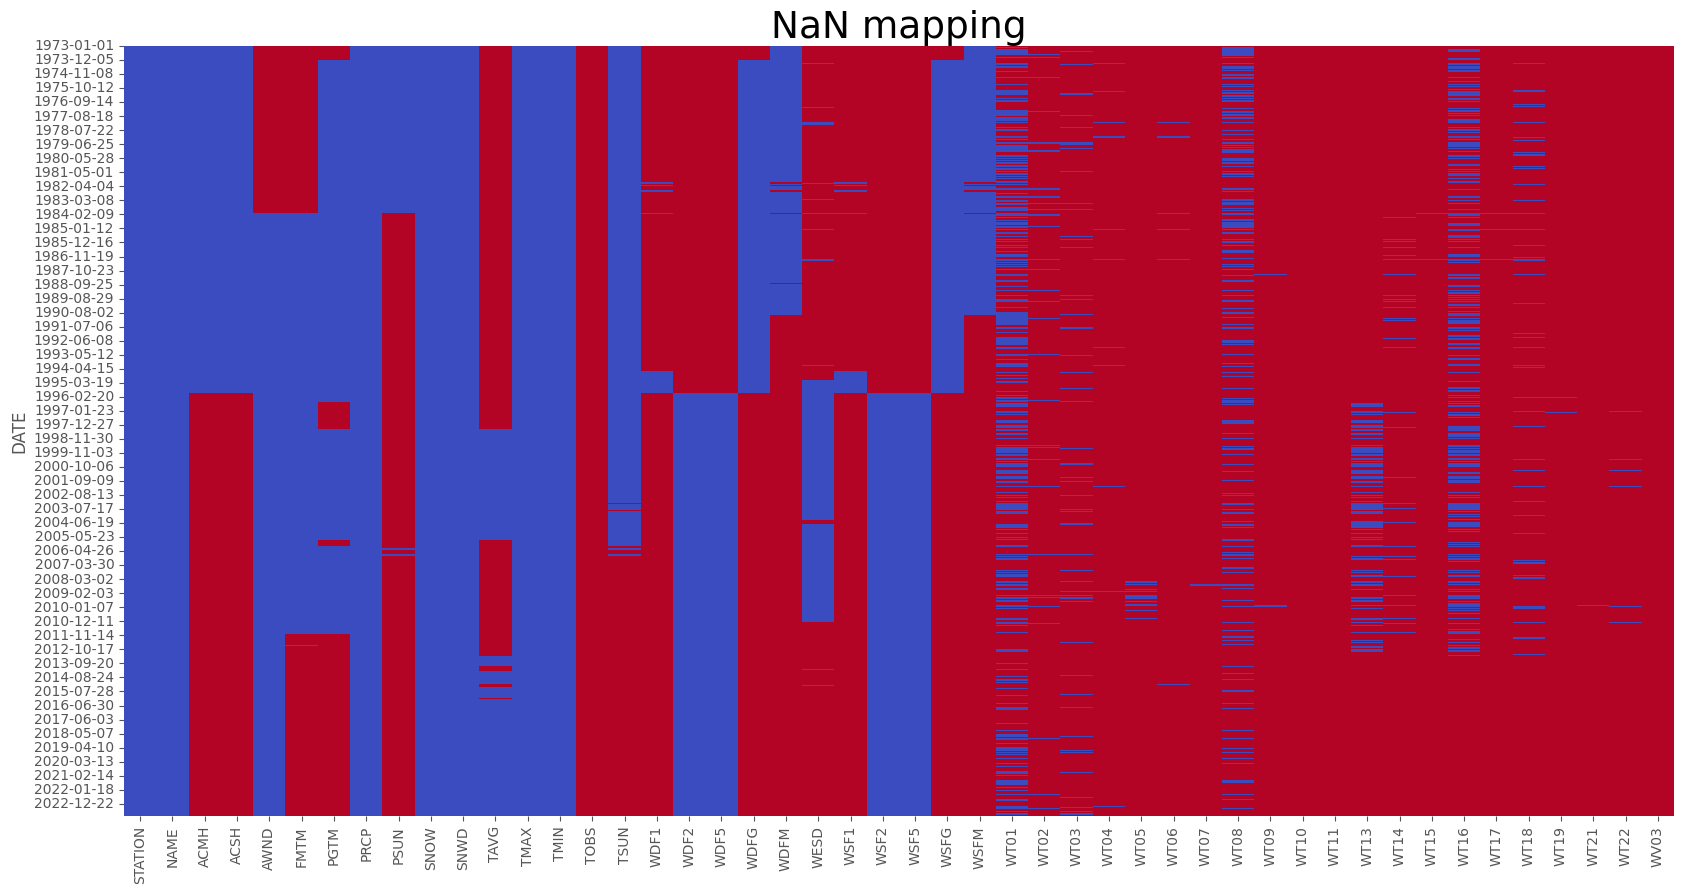

In [5]:
plt.figure(figsize = (20,10))
sns.heatmap(df_weather.isna(),
            cbar = False,
            cmap = "coolwarm",
           cbar_kws={'label': 'Missing Data'}
           )
plt.title('NaN mapping',
          fontsize = 27)
plt.show()


Please notice how the red colour indicates the existance of NaNs. Let us realize this by visualizing the percentage of NaNs:

In [6]:

null_percent = nan_number/df_weather.shape[0] * 1e2
null_percent.sort_values(ascending = False)

WV03       99.994609
WT10       99.994609
TOBS       99.994609
WT21       99.849048
WT19       99.843657
WT15       99.838266
WT11       99.822093
WT22       99.800528
WT09       99.708879
WT07       99.563319
WT17       99.536363
WT06       98.943339
WT04       98.361098
WT05       98.005283
WT02       96.511941
WSF1       96.447248
WDF1       96.447248
WT14       95.493018
WT18       94.387838
WT03       91.972613
WT13       87.142164
PSUN       77.740040
WT08       76.564774
WESD       67.566985
WT16       66.941614
TAVG       65.976603
WDFM       65.690873
WSFM       65.653135
WT01       57.744353
WDFG       56.865599
WSFG       56.849426
ACMH       54.892447
ACSH       54.887056
FMTM       45.236940
WDF5       45.183029
WSF5       45.177638
WSF2       45.123726
WDF2       45.123726
TSUN       34.815893
PGTM       29.985444
AWND       21.672327
SNWD        0.010782
NAME        0.000000
TMIN        0.000000
TMAX        0.000000
SNOW        0.000000
PRCP        0.000000
STATION     0

We don't want to leave out the `SNWD` metric (snow-depth), so we're setting a `null_low_threshold` to 3%, for instance.

In [7]:
study_columns = df_weather.columns[null_percent < 3]
study_columns


Index(['STATION', 'NAME', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN'], dtype='object')

And so we define the columns which will be the object of our study

In [8]:
df2_weather = df_weather[study_columns]

In [9]:
df2_weather.dtypes

STATION     object
NAME        object
PRCP       float64
SNOW       float64
SNWD       float64
TMAX         int64
TMIN         int64
dtype: object

In [23]:
df2_weather

,STATION,NAME,PRCP,SNOW,SNWD,TMAX,TMIN
DATE,,,,,,,
1973-01-01,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.01,0.0,0.0,62,42
1973-01-02,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,46,29
1973-01-03,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.06,0.0,0.0,37,25
1973-01-04,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.50,0.0,0.0,48,34
1973-01-05,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,41,35
...,...,...,...,...,...,...,...
2023-10-10,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,68,50
2023-10-11,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,71,49
2023-10-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,73,50


In [10]:
# there are still some nan values from metrics we want to keep ('snwd')
null_percent_2 = df2_weather.apply(pd.isnull)\
                            .sum()/df2_weather.shape[0] * 1e2

null_percent_2.sort_values(ascending = False)

SNWD       0.010782
STATION    0.000000
NAME       0.000000
PRCP       0.000000
SNOW       0.000000
TMAX       0.000000
TMIN       0.000000
dtype: float64

In [11]:
# propagate the last non-null value foward to the next null value
df2_weather = df2_weather.ffill()

In [12]:
df2_weather.apply(pd.isnull).sum()

STATION    0
NAME       0
PRCP       0
SNOW       0
SNWD       0
TMAX       0
TMIN       0
dtype: int64

In [13]:
# rid the column names from any uppercase
df2_weather.columns = df2_weather\
                            .columns.str.lower()

Index are object type, we better cast them as datetime as it codes below:

In [16]:
df2_weather.index

Index(['1973-01-01', '1973-01-02', '1973-01-03', '1973-01-04', '1973-01-05',
       '1973-01-06', '1973-01-07', '1973-01-08', '1973-01-09', '1973-01-10',
       ...
       '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09',
       '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14'],
      dtype='object', name='DATE', length=18549)

In [14]:
df2_weather.index = pd.to_datetime(df2_weather.index)

Are there gaps in our data? How many time each unique value exists ( value counts), sort index will arrange them in order

In [15]:
df2_weather.index.year

Index([1973, 1973, 1973, 1973, 1973, 1973, 1973, 1973, 1973, 1973,
       ...
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023],
      dtype='int32', name='DATE', length=18549)

In [16]:
df2_weather.index.year\
                 .value_counts().sort_index(ascending = False)

DATE
2023    287
2022    365
2021    365
2020    366
2019    365
2018    365
2017    365
2016    366
2015    365
2014    365
2013    365
2012    366
2011    365
2010    365
2009    365
2008    366
2007    365
2006    365
2005    365
2004    366
2003    365
2002    365
2001    365
2000    366
1999    365
1998    365
1997    365
1996    366
1995    365
1994    365
1993    365
1992    366
1991    365
1990    365
1989    365
1988    366
1987    365
1986    365
1985    365
1984    366
1983    365
1982    365
1981    365
1980    366
1979    365
1978    365
1977    365
1976    366
1975    365
1974    365
1973    365
Name: count, dtype: int64

The records for the year 2023 hasn't been completed yet. The rest of the years contain 365 days, and 366 for the leap ones can be noticed too.


In [20]:
df2_weather.dtypes

station     object
name        object
prcp       float64
snow       float64
snwd       float64
tmax         int64
tmin         int64
dtype: object

The index are 

In [21]:
df2_weather.index

DatetimeIndex(['1973-01-01', '1973-01-02', '1973-01-03', '1973-01-04',
               '1973-01-05', '1973-01-06', '1973-01-07', '1973-01-08',
               '1973-01-09', '1973-01-10',
               ...
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14'],
              dtype='datetime64[ns]', name='DATE', length=18549, freq=None)

(array([ 1096,  3652,  7305, 10957, 14610, 18262, 19644], dtype=int64),
 [Text(1096, 0, ''),
  Text(3652, 0, '1980'),
  Text(7305, 0, '1990'),
  Text(10957, 0, '2000'),
  Text(14610, 0, '2010'),
  Text(18262, 0, '2020'),
  Text(19644, 0, '')])

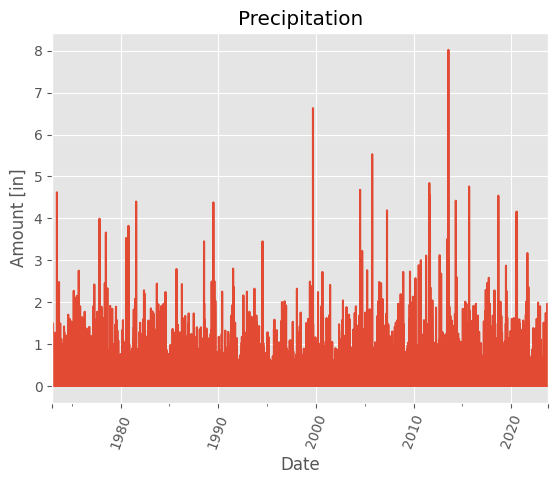

In [17]:
df2_weather["prcp"].plot()
plt.title('Precipitation')
plt.ylabel('Amount [in]')
plt.xlabel('Date')
plt.xticks(rotation = 70)

For each day, we are to try to predict tomorrow's temperature. Create a new column `target`

In [18]:
# shift method keeps the same index while pulling the values from the rows back we indicate 
# ( equivalent to LAG() function in SQL)
df2_weather["target"] = df2_weather.shift(-1)["tmax"]

In [40]:
df2_weather

,station,name,prcp,snow,snwd,tmax,tmin,target
DATE,,,,,,,,
1973-01-01,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.01,0.0,0.0,62,42,46.0
1973-01-02,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,46,29,37.0
1973-01-03,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.06,0.0,0.0,37,25,48.0
1973-01-04,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.50,0.0,0.0,48,34,41.0
1973-01-05,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,41,35,35.0
...,...,...,...,...,...,...,...,...
2023-10-10,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,68,50,71.0
2023-10-11,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,71,49,73.0
2023-10-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,73,50,67.0


In [19]:
# please note we can pull back nothing from beyond the last day of our dataset,
# so use ffil method again
df2_weather = df2_weather.ffill()

In [20]:
# check the result
df2_weather.iloc[-2:]['target']

DATE
2023-10-13    54.0
2023-10-14    54.0
Name: target, dtype: float64

We now briefly check for collinearity for the sake of curiosity and in case we ever used a Regular Linear Regression model. 

Nevertheless, since we are to use Ridge Regression to model our algorithm, this method already adjust/penalizes for collinearity per se.

<Axes: >

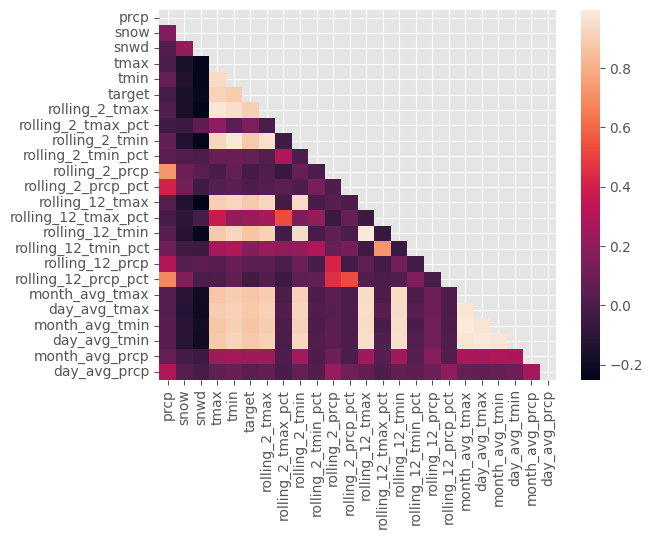

In [59]:
df_corr = df2_weather.copy()
corr = df_corr.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr,
                            dtype = bool))
sns.heatmap(corr.iloc[:,:],
            fmt ='.3f',
            annot = False,
            cmap = "rocket",
            mask = mask
           )

In [33]:
# Select independent variables
X = df2_weather[['tmax', 'tmin', 'target']]

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) 
                     for i in range(X.shape[1])]
vif['Features'] = X.columns

print(vif)

   VIF Factor Features
0  127.749367     tmax
1   67.651514     tmin
2   79.200037   target


In [37]:
# Ridge regression model
rr = Ridge(alpha = .1) 
# Lambda parameter in Ridge regress. remaned alpha as the former was reserved for Python anonym. funct.

Next, we are going to create a list of _predictor_ columns, which are to be used to predict our target:

In [34]:
# assign all the columns of the df except these non numerical three 
predictors = df2_weather.columns[ ~ df2_weather.columns.isin(["target",
                                                              "name",
                                                              "station"])
                                ]

In [38]:
# we are to be using these to perform our judgements
predictors


Index(['prcp', 'snow', 'snwd', 'tmax', 'tmin'], dtype='object')

Moving forward, and as said in the beginning of this notebook, we are to create a function which will execute the Time-Series Cross Validation prediction:


In [35]:
def backtest(df2_weather, model, predictors,
             # how much data we want to take on(days)
             start = 3650,  
              # every 90 days we will create a prediction set
             step = 90): 
    all_predictions = []
    # initial pt., finaliz.pt., iter. lenght
    for i in range(start, df2_weather.shape[0], step): 
        # training set: all data coming before current row
        train = df2_weather.iloc [ : i, : ]      
        # test set: solely next step to make predictions on
        test = df2_weather.iloc [ i : (i + step), : ]  
        # fitting occurs
        model.fit(train [predictors],
                  train ["target"])
        # predictions are generated
        preds = model.predict (test [predictors])
        # convert predictions into Pandas df
        preds = pd.Series(preds,
                          index = test.index)
        # concatenate target values with predictions found
        # treat each of them as separate column
        combined = pd.concat([test ["target"],
                              preds],
                              axis = 1)
        combined.columns = ["actual",
                            "predicted"]
        # abs. value of difference between prediction and actual
        combined["diff"] = (combined["predicted"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
        
    return pd.concat(all_predictions)

In [39]:
predictions = backtest(df2_weather,
                       rr,
                       predictors)

In [34]:
predictions.round(4)

,actual,predicted,diff
DATE,,,
1982-12-30,40.0,41.3439,1.3439
1982-12-31,46.0,44.6296,1.3704
1983-01-01,45.0,48.0036,3.0036
1983-01-02,42.0,47.7257,5.7257
1983-01-03,38.0,44.1620,6.1620
...,...,...,...
2023-10-10,71.0,67.9896,3.0104
2023-10-11,73.0,69.5721,3.4279
2023-10-12,67.0,71.1659,4.1659


We are going to use MAE as our accuracy metric. We can compute it by means of the following and reowned function from scikit-learn library:

In [48]:
mean_absolute_error(predictions["actual"],
                    predictions["predicted"]).round(4)

5.6569

Alternatively, we can code:

In [49]:
predictions["diff"].mean().round(4)

5.6569

This is to say, on average, we were around 5 Farenheit degrees off from the correct temperature.

In [41]:
predictions.sort_values("diff",
                        ascending = False).round(3)

,actual,predicted,diff
DATE,,,
2014-01-06,13.0,50.268,37.268
1998-12-22,27.0,57.351,30.351
2022-12-23,18.0,47.935,29.935
1987-05-18,57.0,85.112,28.112
1992-01-14,33.0,61.028,28.028
...,...,...,...
2018-03-10,46.0,46.003,0.003
2008-10-13,78.0,77.997,0.003
2019-03-24,59.0,59.003,0.003


In order to improve accuracy, we will try to remove any source of bias from our data. 

We are to calculate the average values in the past few days (between a specified horizon range) and we will compare them to the current day. 
These will help us to discard values which were odd or out of the normal trend, these being real difficult to scientifically explain.

In [42]:
# relative change funct.
def relative_diff(old, new):
    return (new - old) / old

 # find rolling avgs (df, days ahead, col.identifier).
def compute_rolling(df2_weather, horizon, col): 
    # iterative format-stringing: name of the new column
    label = f"rolling_{horizon}_{col}"  
    # window calculation for mean funct.,based on days ahead of predict.
    df2_weather[label] = df2_weather[col].rolling(horizon).mean()  
    # compute the rel.diff. calc. between avg. and col. value                                                              
    df2_weather[f"{label}_pct"] = relative_diff(df2_weather[label],  
                                               df2_weather[col])    
    return df2_weather

In [43]:
rolling_horizons = [2, 12]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        # iterate `compute_rolling funct.` for each col. for the mentioned horizon range 
        df2_weather = compute_rolling (df2_weather, horizon, col)

In [53]:
df2_weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_2_tmax,rolling_2_tmax_pct,rolling_2_tmin,rolling_2_tmin_pct,rolling_2_prcp,rolling_2_prcp_pct,rolling_12_tmax,rolling_12_tmax_pct,rolling_12_tmin,rolling_12_tmin_pct,rolling_12_prcp,rolling_12_prcp_pct
DATE,,,,,,,,,,,,,,,,,,,,
1973-01-01,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.01,0.0,0.0,62,42,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-02,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,46,29,37.0,54.0,-0.148148,35.5,-0.183099,0.005,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-03,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.06,0.0,0.0,37,25,48.0,41.5,-0.108434,27.0,-0.074074,0.030,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-04,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.50,0.0,0.0,48,34,41.0,42.5,0.129412,29.5,0.152542,0.280,0.785714,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-05,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,41,35,35.0,44.5,-0.078652,34.5,0.014493,0.250,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-10,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,68,50,71.0,66.0,0.030303,49.0,0.020408,0.010,-1.000000,74.500000,-0.087248,57.083333,-0.124088,0.020000,-1.000000
2023-10-11,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,71,49,73.0,69.5,0.021583,49.5,-0.010101,0.000,NaN,74.750000,-0.050167,56.250000,-0.128889,0.002500,-1.000000
2023-10-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,73,50,67.0,72.0,0.013889,49.5,0.010101,0.000,NaN,74.916667,-0.025584,55.416667,-0.097744,0.002500,-1.000000


There are no rolling values prior to the 1st day of the dataset, hence there are NaN values in that time range. We will be removing these:

In [44]:
# omit the first observations which contain NaN values,
df2_weather = df2_weather.iloc[12 : , : ] 
#
df2_weather = df2_weather.fillna(0)

In [45]:
 # returns the mean of the current row and the all the prev. ones
def expand_mean(df):
    return df.expanding(1).mean()   

In [46]:
for col in ["tmax", "tmin", "prcp"]:
    # computes the mean of 
    # all the past avg.metric of a month and the current one,
    # without any new indexing level
    df2_weather[f"month_avg_{col}"] = df2_weather[col]\
                    .groupby(df2_weather.index.month,
                             group_keys = False)\
                                .apply(expand_mean)
    # likewise with time range `day` 
    df2_weather[f"day_avg_{col}"] = df2_weather[col]\
                    .groupby(df2_weather.index.day_of_year,
                             group_keys = False)\
                                .apply(expand_mean)

By doing this, we are removing any bias that may occur from taking into consideration any observations from anytime after our prediction target. 
Plus, we're getting the average after having grouped by moth and day, respectively.

We are to rerun now the assignation of our list of predictors so as to update this:

In [47]:
predictors = df2_weather.columns[ ~ df2_weather.columns.isin(["target",
                                                              "name",
                                                              "station"])]
predictors

Index(['prcp', 'snow', 'snwd', 'tmax', 'tmin', 'rolling_2_tmax',
       'rolling_2_tmax_pct', 'rolling_2_tmin', 'rolling_2_tmin_pct',
       'rolling_2_prcp', 'rolling_2_prcp_pct', 'rolling_12_tmax',
       'rolling_12_tmax_pct', 'rolling_12_tmin', 'rolling_12_tmin_pct',
       'rolling_12_prcp', 'rolling_12_prcp_pct', 'month_avg_tmax',
       'day_avg_tmax', 'month_avg_tmin', 'day_avg_tmin', 'month_avg_prcp',
       'day_avg_prcp'],
      dtype='object')

In [48]:
predictions = backtest(df2_weather, rr, predictors)
# mean_absolute_error(predictions["actual"],
 #                   predictions["prediction"])

ValueError: Input X contains infinity or a value too large for dtype('float64').

The Kernel complains for there are some infinity  values, we are to spot them and handle them:

In [49]:
df_inf = df2_weather[(df2_weather == np.inf).any(axis = 1)]
df_inf

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_2_tmax,rolling_2_tmax_pct,...,rolling_12_tmin,rolling_12_tmin_pct,rolling_12_prcp,rolling_12_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1977-01-19,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,3.0,22,3,30.0,17.0,0.294118,...,8.333333,-0.640000,0.170,-1.000000,39.839695,41.600000,24.732824,21.4,0.131756,0.144000
1979-02-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.43,4.8,2.0,16,2,15.0,15.0,0.066667,...,13.000000,-0.846154,0.085,4.058824,41.060773,36.857143,23.955801,19.0,0.073867,0.132857


In [50]:
# Replacing infinite with nan 
df2_weather.replace([np.inf, - np.inf],
                    np.nan,
                    inplace = True) 

# Dropping all the rows with nan values 
df2_weather.dropna(inplace = True) 


In [51]:
df_inf = df2_weather[(df2_weather == np.inf).any(axis = 1)]
df_inf

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_2_tmax,rolling_2_tmax_pct,...,rolling_12_tmin,rolling_12_tmin_pct,rolling_12_prcp,rolling_12_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,


In [52]:
predictions = backtest(df2_weather, rr, predictors)


In [53]:
df2_weather

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_2_tmax,rolling_2_tmax_pct,...,rolling_12_tmin,rolling_12_tmin_pct,rolling_12_prcp,rolling_12_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
1973-01-13,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,35,17,40.0,33.0,0.060606,...,21.000000,-0.190476,0.046667,-1.000000,35.000000,35.000000,17.000000,17.000000,0.000000,0.000000
1973-01-14,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,40,19,43.0,37.5,0.066667,...,20.166667,-0.057851,0.046667,-1.000000,37.500000,40.000000,18.000000,19.000000,0.000000,0.000000
1973-01-15,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,43,28,49.0,41.5,0.036145,...,20.416667,0.371429,0.041667,-1.000000,39.333333,43.000000,21.333333,28.000000,0.000000,0.000000
1973-01-16,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,49,27,55.0,46.0,0.065217,...,19.833333,0.361345,0.000000,0.000000,41.750000,49.000000,22.750000,27.000000,0.000000,0.000000
1973-01-17,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,55,30,55.0,52.0,0.057692,...,19.416667,0.545064,0.000000,0.000000,44.400000,55.000000,24.200000,30.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-10,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,68,50,71.0,66.0,0.030303,...,57.083333,-0.124088,0.020000,-1.000000,66.875641,69.019608,48.997436,51.882353,0.105160,0.106863
2023-10-11,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,71,49,73.0,69.5,0.021583,...,56.250000,-0.128889,0.002500,-1.000000,66.878283,68.254902,48.997438,51.392157,0.105093,0.174706
2023-10-12,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,73,50,67.0,72.0,0.013889,...,55.416667,-0.097744,0.002500,-1.000000,66.882202,67.450980,48.998079,50.607843,0.105026,0.062745


In [54]:
mean_absolute_error(predictions["actual"],
                   predictions["predicted"]).round(4)

5.248

The new MAE being lower now which indicates that our predictions got better.

Let us looks into the days which have the biggest difference between the actual and predicted.

In [57]:
predictions.sort_values("diff",
                        ascending = False).round(3)

,actual,predicted,diff
DATE,,,
2014-01-06,13.0,48.143,35.143
2022-12-23,18.0,45.842,27.842
2001-04-08,83.0,55.527,27.473
1987-05-18,57.0,83.926,26.926
1999-01-02,56.0,29.945,26.055
...,...,...,...
2000-03-30,59.0,59.002,0.002
1991-10-07,64.0,63.998,0.002
1999-08-17,90.0,89.999,0.001


We can look into these annomalous days selecting the dates around these:

In [58]:
df2_weather.loc["2022-12-20" : "2022-12-25"].round(3)

,station,name,prcp,snow,snwd,tmax,tmin,target,rolling_2_tmax,rolling_2_tmax_pct,...,rolling_12_tmin,rolling_12_tmin_pct,rolling_12_prcp,rolling_12_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2022-12-20,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,41,27,42.0,39.5,0.038,...,31.833,-0.152,0.179,-1.000,45.424,42.92,30.724,27.94,0.118,0.084
2022-12-21,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,42,26,53.0,41.5,0.012,...,31.167,-0.166,0.179,-1.000,45.421,43.66,30.721,28.60,0.118,0.108
2022-12-22,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.71,0.0,0.0,53,29,59.0,47.5,0.116,...,31.083,-0.067,0.238,1.979,45.426,44.68,30.720,29.78,0.119,0.124
2022-12-23,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.48,0.0,0.0,59,9,18.0,56.0,0.054,...,28.750,-0.687,0.270,0.778,45.435,46.82,30.706,30.32,0.119,0.122
2022-12-24,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,18,7,29.0,38.5,-0.532,...,26.667,-0.738,0.270,-1.000,45.417,44.68,30.691,29.04,0.119,0.163
2022-12-25,USW00013739,"PHILADELPHIA INTERNATIONAL AIRPORT, PA US",0.00,0.0,0.0,29,18,30.0,23.5,0.234,...,26.000,-0.308,0.270,-1.000,45.407,44.52,30.683,29.08,0.119,0.164


We can see that the `target/actual` value drops clearlily on the date `2022-12-23` from the rest of the observation before and after it.

 In order to forestall these kind of biased data, we would be needing more detailed atmospheric data and other parameters such as humidity, solar radiation, barometric pressure or wind and pollution conditions, amongst others.

In [203]:
predictions

,actual,predicted,diff
DATE,,,
1983-01-13,39.0,34.504403,4.495597
1983-01-14,37.0,39.542256,2.542256
1983-01-15,34.0,38.970461,4.970461
1983-01-16,33.0,36.683670,3.683670
1983-01-17,27.0,34.794901,7.794901
...,...,...,...
2023-10-10,71.0,70.820559,0.179441
2023-10-11,73.0,70.974464,2.025536
2023-10-12,67.0,72.171813,5.171813


We can select how many times our error `diff` was a certain amount:

In [216]:
predictions["diff"].round().value_counts().sort_index()

diff
0.0      983
1.0     1843
2.0     1804
3.0     1671
4.0     1445
5.0     1330
6.0     1111
7.0      922
8.0      819
9.0      645
10.0     563
11.0     437
12.0     333
13.0     249
14.0     197
15.0     145
16.0     114
17.0      81
18.0      58
19.0      47
20.0      35
21.0      16
22.0      11
23.0       9
24.0       5
25.0       6
26.0       2
27.0       2
28.0       1
35.0       1
Name: count, dtype: int64

Please notice that these last few ones whose difference are highest are the ones responsible for making our MAE higher.

 We can visualize theses at the right side of the following graphic:

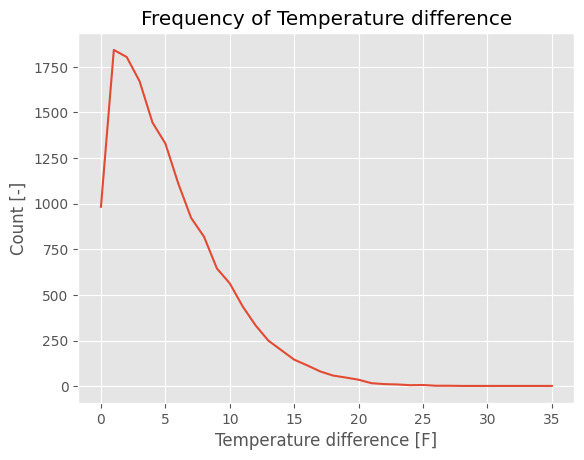

In [60]:
predictions["diff"].round().value_counts().sort_index().plot()
plt.title('Frequency of Temperature difference')
plt.ylabel('Count [-]')
plt.xlabel('Temperature difference [F]')
plt.show()
